# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée](#section_2)

[3. Approche supervisée](#section_3)

[4. Approche supervisée avec Word Embedding : Word2Vec](#section_4)

[5. Approche supervisée avec Word Embedding : BERT](#section_5)

[6. Approche supervisée avec Sentence Embedding : USE](#section_6)

[7. Choix du modèle pour le code final à déployer](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [3]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [4]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned_10000t.csv', encoding='utf8')

In [5]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))

In [6]:
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))

In [7]:
data.head()

,Tags,Texts,Sentences
0,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,...",scope variables delegate found the following r...
1,"[mysql, database, arrays, postgresql, stored-p...","[pas, array, procedure, pas, array, procedure,...",how can pass array values stored procedure wan...
2,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, uibutton, buttonwithtype, figure, butt...",manually setting uibutton state uibutton using...
3,"[database, nhibernate, exception-handling, con...","[check, application, table, column, constraint...",should check for constraints code should catch...
4,"[haskell, f#, functional-programming, language...","[tuple, programming, ocaml, haskell, function,...",typed tuple arguments and curriable arguments ...


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99961 entries, 0 to 99960
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tags       99961 non-null  object
 1   Texts      99961 non-null  object
 2   Sentences  99961 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


Le jeu de données est très important pour les temps de calculs à ma disposition.

Je décide aussi de prendre les observations pour lesquelles la similarité entre les colonnes Texts et Tags est importante.

Cela va me permettre de pouvoir regarder la pertinence des tags que mes modèles vont proposer.

In [9]:
sample_size = 5000

In [10]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

In [11]:
def get_highest_similarity_rows(data, col1, col2, n):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)

In [12]:
data_sample = get_highest_similarity_rows(data, "Tags", "Texts", sample_size)
data_sample = data_sample[['Tags', 'Texts', 'Sentences', 'jaccard_similarity']]
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(5000, 3)


,Tags,Texts,Sentences
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da...",jquery javascript convert date string date hav...
1,"[vba, excel, function, size, byte]","[excel, function, size, byte, return, file, si...",vba excel function for returning file size byt...
2,"[git, timezone, format, timestamp, timezone-of...","[git, timezone, timestamp, format, git, way, t...",git timezone and timestamp format from git can...
3,"[python, request, python-3.x, response, wsgi]","[wsgi, request, response, request, response, c...",wsgi request and response wrappers for python ...
4,"[linux, unix, process, path, environment]","[path, process, linux, environment, path, proc...",how get the path process unix linux windows en...


Afin de mettre en place une méthode d’évaluation propre, je décide de séparer le jeu de données en deux parties : 
 - la première me servira à l'entrainement des modèles
 - la seconde partie me permettra d'évaluer certains modèles sur des données qui leurs sont inconnues

In [13]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],
    test_size=0.2,
    random_state=42
)

In [14]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
sentences = sentences_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [15]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
sentences_eval = sentences_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
flat_tags_eval = [" ".join(tag) for tag in tags_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))
vocabulary_tags_eval = list(set([word for item in tags_list_eval for word in item]))

In [16]:
words = []
for text in flat_tags:
    words.extend(text.split())

counter = Counter(words)
top_500_tags = [word for word, count in counter.most_common(500)]

In [17]:
words = []
for text in flat_tags_eval:
    words.extend(text.split())

counter = Counter(words)
top_200_tags_eval = [word for word, count in counter.most_common(200)]

In [18]:
mlb = MultiLabelBinarizer(classes=top_500_tags)
tags_mlb = mlb.fit_transform(tags_list)

## <font color="#114b98" id="section_2">2. Approche non supervisée</font>

### Étude

In [19]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from tqdm import tqdm
from sklearn.decomposition import PCA

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [20]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test,
    and the list of texts, applies the models to the data and plots 
    the silhouette and coherence scores to help determine the optimal
    number of topics.

    """

    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    for n_topics in tqdm(n_topics_range, ascii=' >='):

        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, 
                                        max_iter=1000)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())

        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())

    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'],
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], 
                                   n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], 
                                  n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()
    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()
    plt.show()

    return scores

In [21]:
# Define the range of number of topics to test
# n_topics_range = range(2, 22, 2)

In [22]:
# Define the range of number of topics to test
n_topics_range = range(2, 6, 2)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [ ]:
models_CountVectorizer = determine_optimal_num_topics(flat_texts,
                                                      CountVectorizer(),
                                                      n_topics_range,
                                                      texts_list)

In [ ]:
models_CountVectorizer

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [ ]:
models_TfidfVectorizer= determine_optimal_num_topics(flat_texts,
                                                     TfidfVectorizer(vocabulary=vocabulary_texts),
                                                     n_topics_range,
                                                     texts_list)

In [ ]:
models_TfidfVectorizer

Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont davantage "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores de silhouette.

Je choisis le nombre de topics au regard des résultats précédents.

In [23]:
n_topics = 30

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [24]:
min_df = 25

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [25]:
max_df = 0.2

In [26]:
vectorizer_CV = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)

In [27]:
vectorizer_TFIDF = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)

In [ ]:
def get_tags_from_text(texts_list, flat_texts, n_topics, vocabulary_texts, min_df, max_df):
    pred_gensim = list()
    pred_sklearn = list()
    pred_tfidf = list()
    pred_count = list()

    # Predict tags using LdaModel (gensim) without bow or TF-IDF
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]
    lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary, random_state=42)
    for text in tqdm(texts_list, ascii=' >='):
        bow = dictionary.doc2bow(text)
        topics = lda.get_document_topics(bow, minimum_probability=0)
        topic_id, prob = max(topics, key=lambda x: x[1])
        topic_words = [w for w, p in lda.show_topic(topic_id, topn=5)]
        pred_gensim.append(topic_words)

    # Predict tags using LDA (sklearn) without bow or TF-IDF
    corpus_dense = corpus2dense(corpus, num_terms=len(dictionary)).T
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(corpus_dense)
    for text in tqdm(texts_list, ascii=' >='):
        bow = dictionary.doc2bow(text)
        dense_bow = corpus2dense([bow], num_terms=len(dictionary)).T[0]
        dense_bow = np.reshape(dense_bow, (1, -1))
        topic_distribution = lda.transform(dense_bow)
        topic_id = topic_distribution.argmax()
        top_words_indices = np.argsort(-lda.components_[topic_id])[:5]
        topic_words = [dictionary[i] for i in top_words_indices]
        pred_sklearn.append(topic_words)

    # Predict tags using LdaModel with TF-IDF
    vectorizer = vectorizer_TFIDF
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tfidf.append(topic_words)

    # Predict tags using LdaModel with CountVectorizer
    vectorizer = vectorizer_CV
    bow = vectorizer.fit_transform(flat_texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topics = lda.fit_transform(bow)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        topic_id = topics.argmax(axis=1)[i]
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_count.append(topic_words)           

    return pred_gensim, pred_sklearn, pred_tfidf, pred_count

In [ ]:
pred_gensim, pred_sklearn, pred_tfidf, pred_count = get_tags_from_text(texts_list,
                                                                       flat_texts,
                                                                       n_topics,
                                                                       vocabulary_texts,
                                                                       min_df,
                                                                       max_df)

In [ ]:
tags_list[0:5]

In [ ]:
pred_gensim[0:5]

In [ ]:
pred_sklearn[0:5]

In [ ]:
pred_tfidf[0:5]

In [ ]:
pred_count[0:5]

Il semblerait que les modèles avec CountVectorizer et TfidfVectorizer prédisent des tags assez similaires à ceux donnés par les utilisateurs.

In [ ]:
pred_tags_list = [pred_gensim, pred_sklearn, pred_tfidf, pred_count]
pred_names = ["gensim", "sklearn", "tfidf", "count"]

In [ ]:
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [ ]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    scoring_methods = ["F1 Score", "Jaccard Score"]
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))

    metrics = {"Jaccard": jaccard_scores, "F1": f1_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set_ylabel('Score')
        axes[i].set_title(scoring_methods[i])
    plt.show()
    return metrics_df

 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [ ]:
evaluate_predictions(tags_mlb, pred_tags_bin_list, pred_names)

Nous observons de meilleurs scores avec un vectorizer.

### Résultats de l'étude

In [28]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1 & s2) / len(s1 | s2)

In [29]:
def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score

In [30]:
def plot_similar_tags(true_tags, pred_tags, method):
    mean_score = calculate_scores(true_tags, pred_tags)
    similar_counts = []
    
    for pred_tags, true_tags in zip(pred_tags, true_tags):
        similar_words = set(pred_tags) & set(true_tags)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    # Add missing keys to counter with value 0
    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))
        
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14, fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0,6,1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n nombre de tags similaires", fontsize=12)   
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(), autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8}, title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n un nombre de tags similaires", fontsize=12)
    
    textstr = ''.join((
        r'Jaccard_index = %.2f' % (mean_score, )))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)
    plt.show()

In [ ]:
plot_similar_tags(tags_list, pred_gensim, 'LDA Gensim')

In [ ]:
plot_similar_tags(tags_list, pred_sklearn, 'LDA Sklearn')

In [ ]:
plot_similar_tags(tags_list, pred_tfidf, 'LDA + TFIDF')

In [ ]:
plot_similar_tags(tags_list, pred_count, 'LDA + Count')

Les vectorizers apportent une réelle plus value avec davantage de tags prédis similaires aux tags originaux.

### LDA + TF-IDF +  PCA

In [ ]:
# Predict tags using LdaModel with TF-IDF
vectorizer = vectorizer_TFIDF
bow = vectorizer.fit_transform(flat_texts)

# Apply PCA to the TF-IDF matrix
pca = PCA()
pca_bow = pca.fit_transform(bow.toarray())

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the explained variance
axs[0].plot(np.cumsum(explained_variance))
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Explained Variance (%)")
axs[0].axhline(y=0.90, linewidth=2, color='black')
axs[0].text(2, 0.91, 'Seuil des 90% de variance', fontsize=14)

# Scatter Plot of PCA Results
axs[1].scatter(pca_bow[:, 0], pca_bow[:, 1])
axs[1].set_xlabel("First Principal Component")
axs[1].set_ylabel("Second Principal Component")
axs[1].set_title("Scatter Plot of PCA Results")

plt.tight_layout()
plt.show()

In [ ]:
def ensure_positive_pca(X):
    pca = PCA(n_components=0.90)
    X_transformed = pca.fit_transform(X)
#     if (X_transformed < 0).sum() > 0:
#         X_transformed -= X_transformed.min()
    return X_transformed

In [ ]:
pca_bow = ensure_positive_pca(bow.toarray())

In [ ]:
# Predict tags using LdaModel with CountVectorizer
pred_tfidf_pca = list()
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(pca_bow)
for i in tqdm(range(len(texts_list)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    top_words_indices = pca_bow[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_pca.append(topic_words)  

In [ ]:
pred_tfidf_pca[0:5]

In [ ]:
tags_list[0:5]

In [ ]:
plot_similar_tags(tags_list, pred_tfidf_pca, 'LDA + TFIDF + PCA')

PCA est une méthode non supervisée qui cherche à identifier les composantes principales ou les caractéristiques qui expliquent la variance la plus importante dans les données. Bien qu'il puisse être utilisé pour la réduction de la dimensionnalité et la visualisation, il ne garantit pas que les caractéristiques transformées soient liées à la cible. Dans votre cas, les caractéristiques transformées PCA semblent avoir perdu le sens sémantique des mots d'origine. Cela peut être dû à diverses raisons, telles que le choix de n_components ou la petite taille de l'ensemble de données.

In [ ]:
# Predict tags using NMF with CountVectorizer
pred_tfidf_pca_nmf = []
nmf = NMF(n_components=n_topics, random_state=42)
topics = nmf.fit_transform(pca_bow)
for i in range(len(texts_list)):
    topic_id = topics.argmax(axis=1)[i]
    top_words_indices = pca_bow[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_pca_nmf.append(topic_words)

### LDA + CountVectorizer +  PCA 

In [ ]:
# Predict tags using LdaModel with CountVectorizer
vectorizer = vectorizer_CV
bow = vectorizer_CV.fit_transform(flat_texts)

# Apply PCA to the count matrix
pca = PCA()
pca_bow = pca.fit_transform(bow.toarray())

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the explained variance
axs[0].plot(np.cumsum(explained_variance))
axs[0].set_xlabel("Number of Components")
axs[0].set_ylabel("Explained Variance (%)")
axs[0].axhline(y=0.90, linewidth=2, color='black')
axs[0].text(2, 0.91, 'Seuil des 90% de variance', fontsize=14)

# Scatter Plot of PCA Results
axs[1].scatter(pca_bow[:, 0], pca_bow[:, 1])
axs[1].set_xlabel("First Principal Component")
axs[1].set_ylabel("Second Principal Component")
axs[1].set_title("Scatter Plot of PCA Results")

plt.tight_layout()
plt.show()

In [ ]:
pca_bow = ensure_positive_pca(bow.toarray())

In [ ]:
# Predict tags using LdaModel with CountVectorizer
pred_count_pca = list()
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(pca_bow)
for i in tqdm(range(len(texts_list)), ascii=' >='):
    topic_id = topics.argmax(axis=1)[i]
    top_words_indices = pca_bow[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_count_pca.append(topic_words)           

In [ ]:
plot_similar_tags(tags_list, pred_count_pca, 'LDA + Count + PCA')

## <font color="#114b98" id="section_3">3. Approche supervisée</font>

### Étude

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
               RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

In [ ]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifiers):

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier',
                                       'F1 Score',
                                       'Jaccard Score',
                                       'Time (s)'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)

    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in tqdm(classifiers, ascii=' >='):
        start_time = time.time()
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)
        end_time = time.time()

        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)
        time_taken = round(end_time - start_time, 4)

        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                        'F1 Score': f1,
                                        'Jaccard Score': jaccard,
                                        'Time (s)': time_taken},
                                        ignore_index=True)

    return results_df

In [ ]:
results_CountVectorizer = calculate_supervised_scores(flat_texts,
                                                      tags_mlb,
                                                      vectorizer_CV,
                                                      classifiers)

In [ ]:
results_CountVectorizer

In [ ]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)

    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['F1 Score', 'Jaccard Score', 'Time (s)']

    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i], 
                    palette=my_palette, 
                    label=scoring_method)

    # Add classifier names to x-axis
    for i in range(3):
        axs[i].set_title(scoring_methods[i])
        axs[i].set_xticks(x)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Score')
        axs[i].set_xticklabels(results_df['Classifier'], rotation=90)

    plt.show()

In [ ]:
plot_results(results_CountVectorizer)

In [ ]:
results_TfidfVectorizer = calculate_supervised_scores(flat_texts,
                                                      tags_mlb,
                                                      vectorizer_TFIDF,
                                                      classifiers)

In [ ]:
results_TfidfVectorizer

In [ ]:
plot_results(results_TfidfVectorizer)

Le SGDClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

Le modèle avec RandomForestClassifier nécessite un temps d'entraînement très long.

Le classificateur LogisticRegression semble assez performant avec CountVectorizer.

### LogisticRegression + GridSearchCV

In [ ]:
results_LR = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_LR = results_LR.append(results_CountVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR = results_LR.append(results_TfidfVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_LR

In [ ]:
plot_results(results_LR)

CountVectorizer permet d'avoir des performances largement supérieures à TF-IDF.

In [ ]:
classifier_LR = LogisticRegression(random_state=42, max_iter=300, tol=1e-5)

In [ ]:
parameters_LR = {'estimator__C': [0.01, 0.1, 0.01],
                 'estimator__penalty': ['l1', 'l2'],
                 'estimator__solver': ['lbfgs', 'liblinear']}

In [ ]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifier, parameters):
    results_df = pd.DataFrame(columns=['Classifier', 'F1 Score', 'Jaccard Score', 'Time (s)'])
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    ovrc = OneVsRestClassifier(classifier)
    clf = GridSearchCV(ovrc, parameters, cv=5, verbose=2)
    
    start_time = time.time()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    end_time = time.time()
    
    best_params = clf.best_params_ if hasattr(clf, 'best_params_') else None
    
    f1 = round(f1_score(y_test, y_pred, average='samples'), 4)
    jaccard = round(jaccard_score(y_test, y_pred, average='samples'), 4)
    time_taken = round(end_time - start_time, 4)
    
    results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                    'F1 Score': f1,
                                    'Jaccard Score': jaccard,
                                    'Time (s)': time_taken},
                                    ignore_index=True)
    return results_df, best_params

In [ ]:
results_LR, best_params_LR = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer_CV,
                                                         classifier_LR,
                                                         parameters_LR)

In [ ]:
results_LR

Ce modèle est légèrement amélioré mais il reste toujours très inférieur au modèle non hyperparamétré avec SGDClassifier.

### SGDClassifier + GridSearchCV

In [ ]:
results_SGD = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_SGD = results_SGD.append(results_CountVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD = results_SGD.append(results_TfidfVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_SGD

In [ ]:
plot_results(results_SGD)

CountVectorizer permet d'avoir des performances légèrement supérieures à TF-IDF.

In [ ]:
classifier_SGD = SGDClassifier(random_state=42)

In [ ]:
parameters_SGD = {'estimator__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__loss': ['hinge', 'log', 'modified_huber'],
                  'estimator__penalty': ['l1', 'l2', 'elasticnet']}

In [ ]:
results_SGD, best_params_SGD = calculate_supervised_scores(flat_texts,
                                                           tags_mlb,
                                                           vectorizer_CV,
                                                           classifier_SGD,
                                                           parameters_SGD)


In [ ]:
results_SGD

In [ ]:
best_params_SGD

In [ ]:
results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier']

In [ ]:
results_CV = pd.concat([results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier'],
                        results_SGD])
results_CV.iloc[1,0] = 'SGDClassifier_CV'
results_CV

In [ ]:
# Call the plot_results function
plot_results(results_CV)

Le modèle a bien pu être amélioré par Cross-Validation.

### Résultats de l'étude

In [ ]:
params = {key.replace('estimator__', ''): value for key, value in best_params_SGD.items()}

In [ ]:
classifier = SGDClassifier(random_state=42, **params)

In [ ]:
ovrc = OneVsRestClassifier(classifier)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
X_train = vectorizer.fit_transform(X_train)
ovrc.fit(X_train, y_train)

In [ ]:
def get_top_5_tags(text, vectorizer, mlb, classifier):
    X = vectorizer.transform([text])
    scores = classifier.decision_function(X)
    top_5 = scores.argsort(axis=1)[:, :5][::-1]
    top_5_tags = [mlb.classes_[i] for i in top_5.flatten()]
    return top_5_tags

In [ ]:
tags_SGDC = []
for text in tqdm(flat_texts_eval):
    top_5_tags = get_top_5_tags(text, vectorizer_CV, mlb, ovrc)
    tags_SGDC.append(top_5_tags)

In [ ]:
tags_SGDC[0:5]

In [ ]:
tags_list_eval[0:5]

In [ ]:
plot_similar_tags(tags_list_eval, tags_SGDC, 'Count + SGDClassifier')

## <font color="#114b98" id="section_4">4. Approche supervisée avec Word Embedding : Word2Vec</font>

### Dataset d'essais

### Word2Vec+ Classifier

### Résultats

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : BERT</font>

### Étude

## <font color="#114b98" id="section_6">6. Approche supervisée avec Sentence Embedding : USE</font>

### Étude

In [31]:
from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub

In [32]:
import gensim
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
import multiprocessing
import transformers
from transformers import BertModel, BertTokenizer
import tensorflow
from keras.utils.vis_utils import plot_model
from keras.layers import Reshape, Flatten, Input
import tensorflow as tf

In [33]:
def extract_keywords(input_text):
    # Load the USE model
    model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    all_keywords = []
    # Encode all the sentences in the input text
    embeddings = model(input_text)
    # Compute the cosine similarity between all the sentences
    similarity_matrix = cosine_similarity(embeddings)
    # Iterate over the list of sentences
    for i in range(len(input_text)):
        # Find the most similar sentences
        most_similar = np.argsort(-similarity_matrix[i])[1:6]
        # Combine the most similar sentences with the current sentence
        text = ' '.join([input_text[j] for j in most_similar])
        # Extract the keywords from the combined text using RAKE
        keyword_extractor = Rake()
        keyword_extractor.extract_keywords_from_text(text)
        word_degrees = keyword_extractor.get_word_degrees()
        sorted_word_degrees = sorted(word_degrees.items(), key=lambda x: x[1], reverse=True)
        keywords = [word for word, degree in sorted_word_degrees[:5]]
        all_keywords.append(keywords)
    return all_keywords

In [34]:
keywords = extract_keywords(sentences)

In [35]:
keywords[0:5]

[['android', 'emulator', 'device', 'try', 'wifi'],
 ['using', 'send', 'email', 'outlook', 'calendar'],
 ['html', 'python', 'convert', 'image', 'exe'],
 ['docker', 'keycloak', 'exec', 'install', 'container'],
 ['error', 'xcode', 'target', 'project', 'lldb']]

In [36]:
tags_list[0:5]

[['android', 'shell', 'configuration', 'adb', 'avd'],
 ['javascript', 'node.js', 'email', 'calendar', 'outlook'],
 ['javascript', 'html', 'css', 'visual-studio-2010', 'exe'],
 ['bash', 'docker', 'shell', 'dockerfile', 'alpine-linux'],
 ['xcode', 'build', 'compilation', 'include', 'target']]

### Résultats

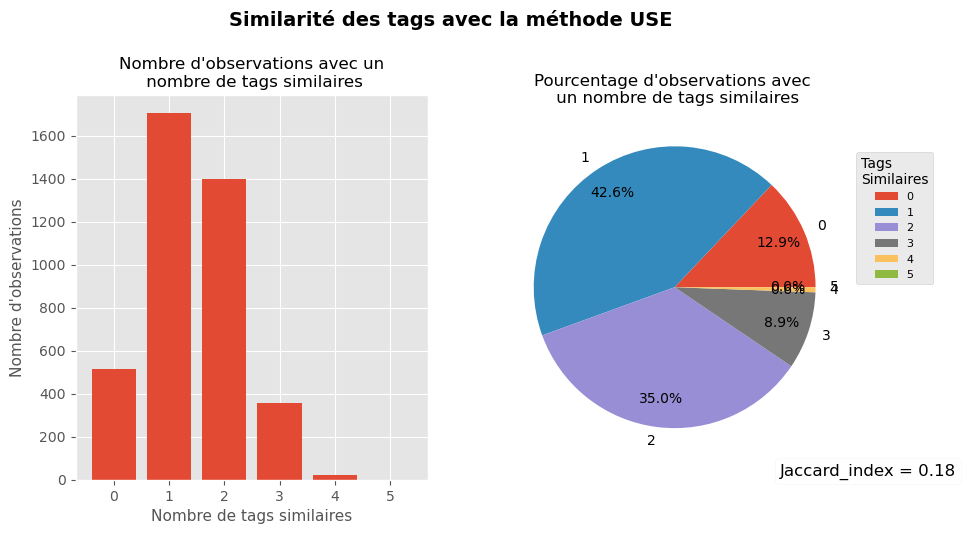

In [37]:
plot_similar_tags(tags_list, keywords, 'USE + Cosine Similarity')

# 2ème approche USE + NN

In [38]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"

In [39]:
use_layer = hub.KerasLayer(module_url)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(sentences, tags_mlb, test_size=0.2, random_state=42)

In [43]:
def use_encode(texts, max_len=512):
    embeddings = use_layer(texts)['outputs']
    return embeddings.numpy()

In [44]:
use_train = use_encode(X_train, max_len=100)

In [47]:
use_test = use_encode(X_test, max_len=100)

In [48]:
# Define the neural network
bert_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(512,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [49]:
# Compile the model
bert_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# Train the model and store the history object
history = bert_nn_model.fit(use_train, y_train, verbose=1, 
                            epochs=200, batch_size=32, 
                            validation_data=(use_test, y_test))

Epoch 1/200
100/100 [==============================] - 1s 5ms/step - loss: 0.6989 - accuracy: 0.0106 - val_loss: 0.4733 - val_accuracy: 0.0000e+00
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 0.3472 - accuracy: 0.1384 - val_loss: 0.1098 - val_accuracy: 0.3487
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 0.1037 - accuracy: 0.3375 - val_loss: 0.0487 - val_accuracy: 0.3750
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0552 - accuracy: 0.3784 - val_loss: 0.0405 - val_accuracy: 0.3738
Epoch 5/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0447 - accuracy: 0.4094 - val_loss: 0.0366 - val_accuracy: 0.4462
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0400 - accuracy: 0.4459 - val_loss: 0.0342 - val_accuracy: 0.4925
Epoch 7/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0381 - accuracy: 0.4594 - val_loss: 0.0326 - val_accuracy: 0.

Epoch 58/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.5553 - val_loss: 0.0195 - val_accuracy: 0.6050
Epoch 59/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0209 - accuracy: 0.5478 - val_loss: 0.0194 - val_accuracy: 0.5788
Epoch 60/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0208 - accuracy: 0.5503 - val_loss: 0.0194 - val_accuracy: 0.5813
Epoch 61/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0208 - accuracy: 0.5437 - val_loss: 0.0193 - val_accuracy: 0.5850
Epoch 62/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0206 - accuracy: 0.5466 - val_loss: 0.0192 - val_accuracy: 0.5875
Epoch 63/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0206 - accuracy: 0.5516 - val_loss: 0.0192 - val_accuracy: 0.5938
Epoch 64/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0206 - accuracy: 0.5559 - val_loss: 0.0192 - val_accuracy:

Epoch 115/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.5078 - val_loss: 0.0185 - val_accuracy: 0.5362
Epoch 116/200
100/100 [==============================] - 0s 3ms/step - loss: 0.0171 - accuracy: 0.5172 - val_loss: 0.0185 - val_accuracy: 0.5500
Epoch 117/200
100/100 [==============================] - 0s 3ms/step - loss: 0.0170 - accuracy: 0.5150 - val_loss: 0.0184 - val_accuracy: 0.5688
Epoch 118/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0169 - accuracy: 0.5144 - val_loss: 0.0185 - val_accuracy: 0.5738
Epoch 119/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0169 - accuracy: 0.5219 - val_loss: 0.0184 - val_accuracy: 0.5600
Epoch 120/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.5209 - val_loss: 0.0183 - val_accuracy: 0.5350
Epoch 121/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0168 - accuracy: 0.5253 - val_loss: 0.0183 - val_ac

100/100 [==============================] - 0s 4ms/step - loss: 0.0153 - accuracy: 0.5113 - val_loss: 0.0185 - val_accuracy: 0.5100
Epoch 172/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0154 - accuracy: 0.4878 - val_loss: 0.0186 - val_accuracy: 0.5250
Epoch 173/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0151 - accuracy: 0.5088 - val_loss: 0.0185 - val_accuracy: 0.5288
Epoch 174/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0153 - accuracy: 0.4988 - val_loss: 0.0186 - val_accuracy: 0.5400
Epoch 175/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.5175 - val_loss: 0.0185 - val_accuracy: 0.5325
Epoch 176/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0149 - accuracy: 0.5103 - val_loss: 0.0185 - val_accuracy: 0.5462
Epoch 177/200
100/100 [==============================] - 0s 4ms/step - loss: 0.0152 - accuracy: 0.4947 - val_loss: 0.0186 - val_accuracy: 0.5500

In [51]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

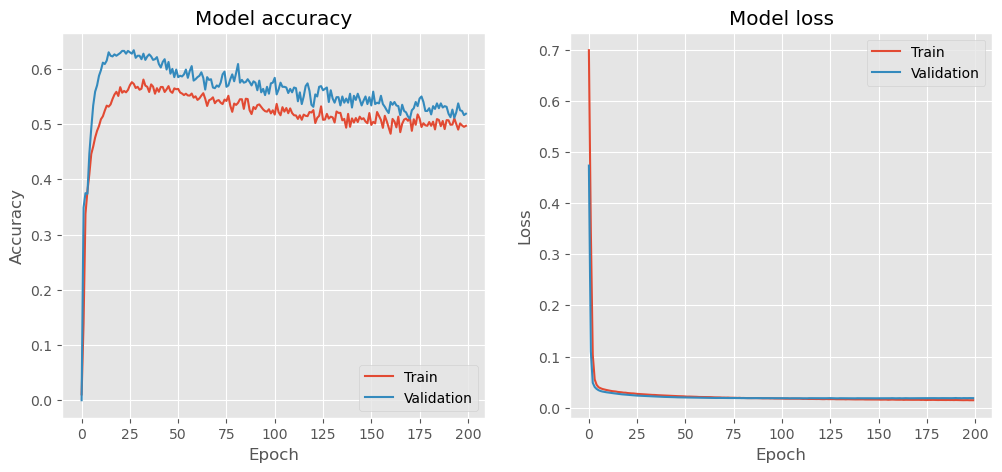

In [52]:
plot_epochs(history)

In [53]:
# Use the trained model to predict the tags for each sentence
pred_probs = bert_nn_model.predict(use_test)

25/25 [==============================] - 0s 1ms/step


In [54]:
# Find the top 5 tags for each sentence
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [55]:
pred_tags[0:5]

[['html', 'javascript', 'jquery', 'css', 'input'],
 ['haskell', 'scala', 'c#', 'list', 'java'],
 ['video', 'html', 'javascript', 'api', 'audio'],
 ['android', 'image', 'imageview', 'java', 'view'],
 ['python', 'c++', 'boost', 'c', 'gcc']]

In [56]:
true_tags_ = mlb.inverse_transform(y_test)
true_tags_[0:5]

[('javascript', 'html', 'jquery', 'input'),
 ('interface', 'haskell'),
 ('javascript', 'html', 'api', 'video'),
 ('android', 'image', 'screen', 'imageview', 'bitmap'),
 ('python', 'c++', 'python-3.x', 'boost')]

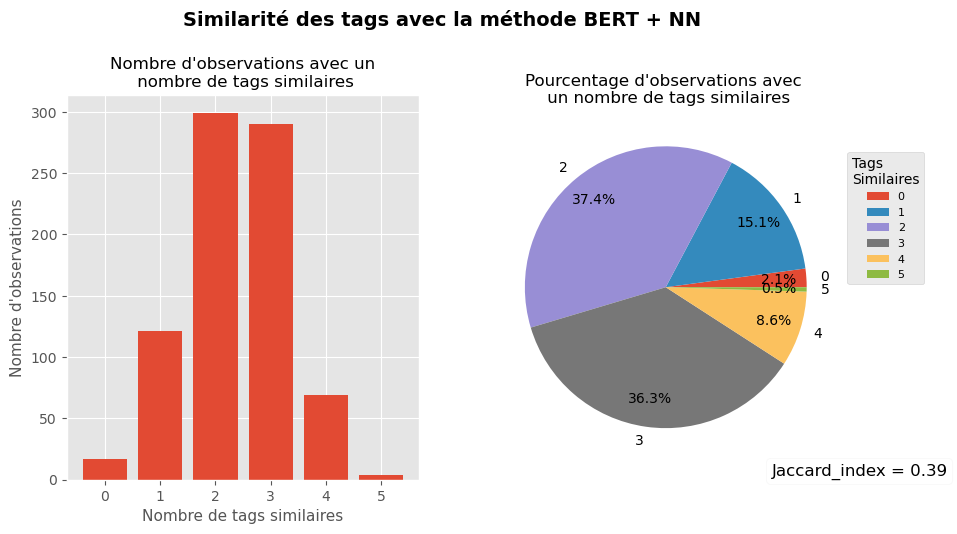

In [57]:
plot_similar_tags(true_tags_, pred_tags, 'USE + NN')

## <font color="#114b98" id="section_7">7. Choix du modèle pour le code final à déployer</font>

Nous allons maintenant comparer les différents modèles à l'aide de leurs résultats sur le dataset de tests.